In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

In [2]:
# 한글 사용
import matplotlib
from matplotlib import font_manager, rc
import platform
if platform.system()=="Windows":
    font_name=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('./data/diabetes.csv')

In [4]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


## 1. 결측치
Glucose, BloodPressure, SkinThickness, Insulin, BMI열에서 0의 값은 결측치일 것이다

### 1.1 결측치가 있는 행 시각화

In [5]:
missing_value_rows = []
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    missing_value_rows += df.index[df[col] == 0].to_list()

In [6]:
missing_value_rows = list(set(missing_value_rows))
len(missing_value_rows)

376

In [7]:
df.loc[missing_value_rows, :]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
5,5,116,74,0,0,25.6,0.201,30,0
7,10,115,0,0,0,35.3,0.134,29,0
...,...,...,...,...,...,...,...,...,...
761,9,170,74,31,0,44.0,0.403,43,1
762,9,89,62,0,0,22.5,0.142,33,0
764,2,122,70,27,0,36.8,0.340,27,0
766,1,126,60,0,0,30.1,0.349,47,1


### 1.2 결측치 채우기
Glucose, BloodPressure, SkinThickness, Insulin, BMI 열에서  
각 열별로 0인 값들의 행을 딕셔너리로 저장한다  
  
각 열별로 0인 값의 행들(A) <-> A를 제외한 나머지 행들(B) 사이의 유사도를 구해서  
가장 유사한 행을 찾아서 그 값을 0에 넣는다

In [8]:
col_and_row_of_zeros = {}
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    col_and_row_of_zeros[col] = df.index[df[col] == 0].to_list()

In [9]:
def get_distance_from_target(row, target):
    distance = sum((row - target) ** 2) ** 0.5
    return distance

In [10]:
# col : 각 열
# rows : 각 열에서 값이 0인 행 번호들
# targets : 나머지 열과 비교해서 0인 값을 채워 넣어야 하는 행들
# distances_from_target : target과 targets 행들을 제외한 data와의 모든 열과의 거리를 저장한 시리즈
# indexes_of_people_who_are_similar_to_the_target :
# target과 targets 행들을 제외한 data의 모든 거리중 최소값을 저장해놓은 리스트


def fill_df(df, col_and_row_of_zeros):
    
    data = df.copy()
    

    for col,rows in col_and_row_of_zeros.items():

        standardized_data = pd.DataFrame(ss.zscore(data), columns=df.columns)
        targets = standardized_data.loc[rows]
        standardized_data.drop(rows, inplace=True)

        indexes_of_people_who_are_similar_to_the_target = []

        for row in rows:
            target = targets.loc[row]
            distances_from_target = standardized_data.apply(get_distance_from_target, axis=1, target=target)
            indexes_of_people_who_are_similar_to_the_target.append(distances_from_target.idxmin())

        values_of_people_similar_to_the_target = data.loc[indexes_of_people_who_are_similar_to_the_target, col]
        df.loc[rows, col] = values_of_people_similar_to_the_target.values
    return df

In [11]:
df = fill_df(df, col_and_row_of_zeros)

## 2. Outcome 컬럼과 다른 컬럼간의 비교

In [12]:
intervals = {}
# 각 열의 값을 매우 낮은, 낮은, 중간, 높은, 매우 높은 으로 구분 
# interval은 나중에 또 쓸일이 있어서 따로 외부 변수에도 저장하고 있음
for col in df.columns[:-1]:
    labels = ['Very Low', 'Low', 'Mid', 'High', 'Very High']
    interval = np.linspace(df[col].min(), df[col].max(), 6)
    intervals[col] = interval
    classification_col_name = col + "_classification"
    df[classification_col_name] =  pd.cut(df[col], bins = interval, labels=labels, include_lowest=True)

In [13]:
classification_and_outcome = df.loc[:,'Pregnancies_classification':'Age_classification']
classification_and_outcome['Outcome'] = df.Outcome

In [14]:
classification_and_outcome

,Pregnancies_classification,Glucose_classification,BloodPressure_classification,SkinThickness_classification,Insulin_classification,BMI_classification,DiabetesPedigreeFunction_classification,Age_classification,Outcome
0,Low,High,Mid,Low,Very Low,Low,Low,Mid,1
1,Very Low,Low,Mid,Low,Very Low,Very Low,Very Low,Very Low,0
2,Mid,Very High,Mid,Very Low,Very Low,Very Low,Low,Very Low,1
3,Very Low,Low,Mid,Very Low,Very Low,Low,Very Low,Very Low,0
4,Very Low,Mid,Very Low,Low,Very Low,Mid,Very High,Very Low,1
...,...,...,...,...,...,...,...,...,...
763,Mid,Low,Mid,Mid,Very Low,Low,Very Low,High,0
764,Very Low,Mid,Mid,Low,Very Low,Low,Very Low,Very Low,0
765,Low,Mid,Mid,Very Low,Very Low,Very Low,Very Low,Very Low,0
766,Very Low,Mid,Low,Very Low,Very Low,Low,Very Low,Mid,1


In [15]:
# 위 데이터 프레임에서 각 열별 Very Low, Low, Mid, High, Very High의
# Outcome열의  0, 1, 총합을 보여주는 crosstable을 저장

classification_name_and_crosstab_dict = {}

for col in classification_and_outcome:
    temp = pd.crosstab(classification_and_outcome[col],
                     classification_and_outcome.Outcome,
                     margins=True) # pd.crosstab(행, 열)
    classification_name_and_crosstab_dict[col] = temp

In [16]:
print("임신 구간 :", np.round(intervals['Pregnancies'], 0))
classification_name_and_crosstab_dict['Pregnancies_classification']

임신 구간 : [ 0.  3.  7. 10. 14. 17.]


Outcome,0,1,All
Pregnancies_classification,,,
Very Low,311,113,424
Low,115,60,175
Mid,60,75,135
High,14,16,30
Very High,0,4,4
All,500,268,768


In [17]:
classification_name_and_crosstab_dict['Age_classification']

Outcome,0,1,All
Age_classification,,,
Very Low,352,122,474
Low,88,88,176
Mid,32,44,76
High,26,13,39
Very High,2,1,3
All,500,268,768


In [18]:
# 위와 같은 crosstable로부터 각 항목들 (임신, 혈압 등..)의
# 구간별(Very Low, Low, Mid, High, Very High) Outcome 비율(발병 비율)을 구함

rates = {}
for name, crosstab in classification_name_and_crosstab_dict.items():
    if name == 'Outcome':
        continue
    rate = (crosstab[1] / crosstab['All']) * 100
    rates[name] = rate.iloc[:5]

In [19]:
rates

{'Pregnancies_classification': Pregnancies_classification
 Very Low      26.650943
 Low           34.285714
 Mid           55.555556
 High          53.333333
 Very High    100.000000
 dtype: float64,
 'Glucose_classification': Glucose_classification
 Very Low      6.666667
 Low          12.500000
 Mid          33.928571
 High         57.246377
 Very High    84.722222
 dtype: float64,
 'BloodPressure_classification': BloodPressure_classification
 Very Low     18.750000
 Low          25.988701
 Mid          35.227273
 High         46.341463
 Very High    58.333333
 dtype: float64,
 'SkinThickness_classification': SkinThickness_classification
 Very Low      26.433915
 Low           43.076923
 Mid           50.000000
 High         100.000000
 Very High    100.000000
 dtype: float64,
 'Insulin_classification': Insulin_classification
 Very Low     31.490015
 Low          52.173913
 Mid          58.823529
 High         80.000000
 Very High    33.333333
 dtype: float64,
 'BMI_classification': 

## 3. 시각화

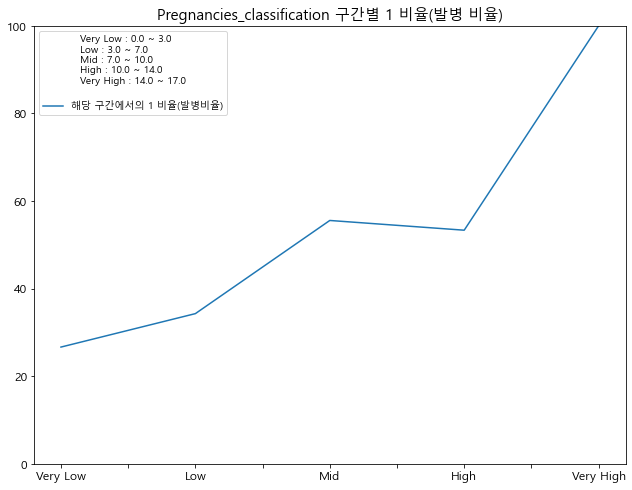

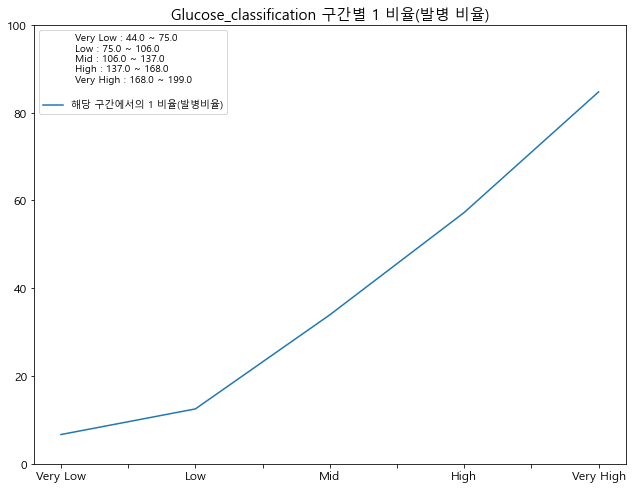

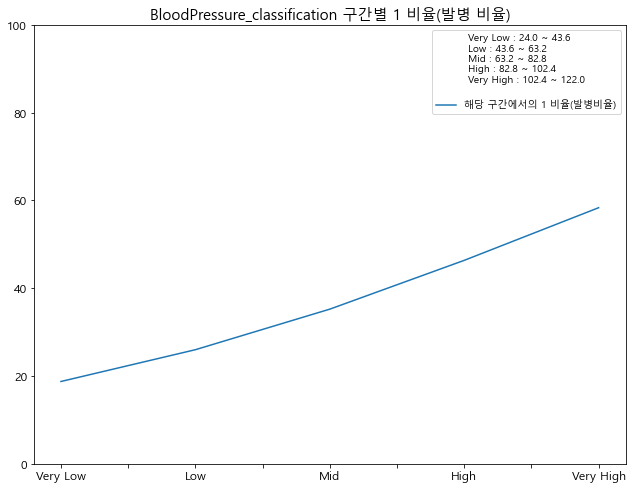

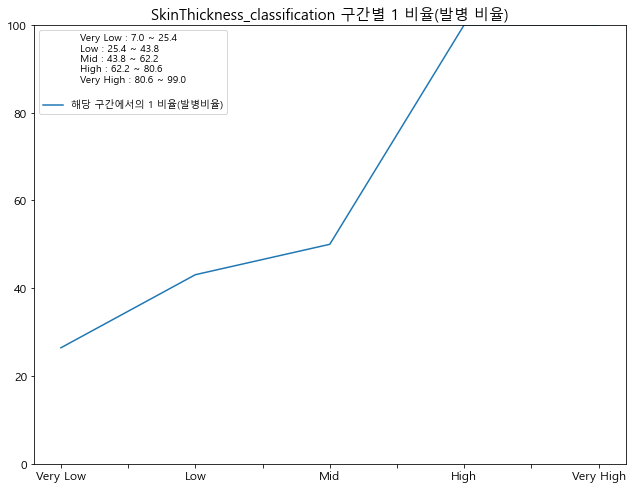

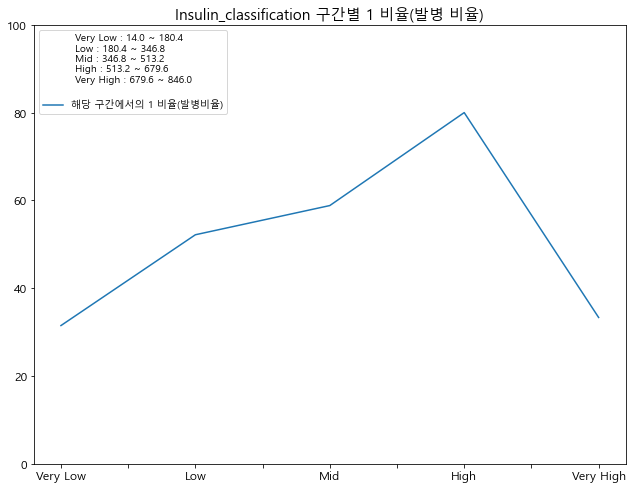

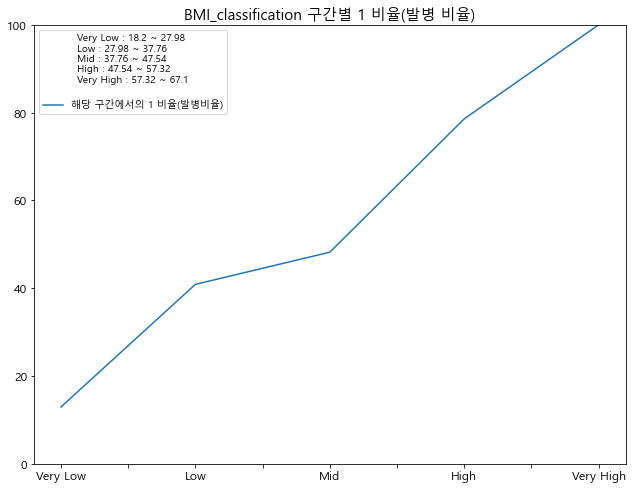

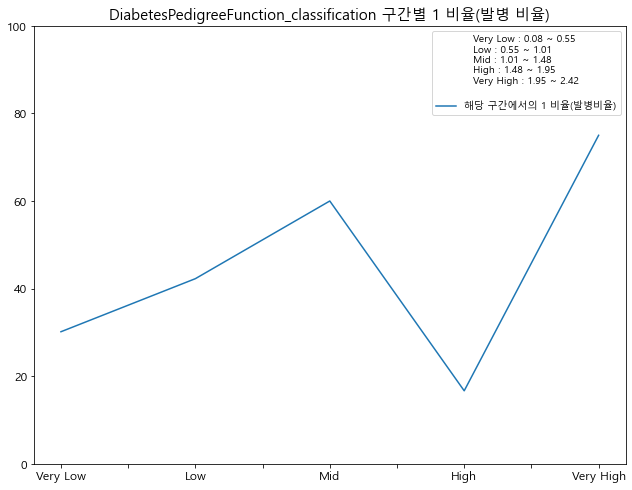

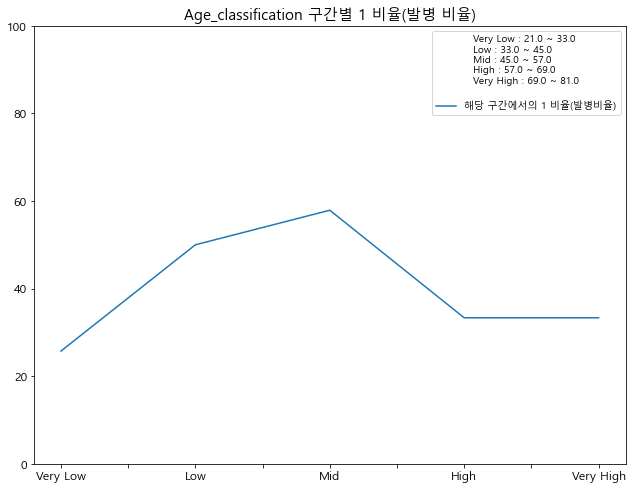

In [20]:
for name, rate in rates.items():
    fig, ax = plt.subplots()
    title = name + " 구간별 1 비율(발병 비율)"
    rate.plot(rot=0, xlabel='', figsize=(10,8), ax=ax, fontsize=12, ylim=[0,100])
    plt.title(title, size=15)
    plt.tight_layout(5)
    k = name.split('_')[0]
    
    legend_title = ""
    for i in range(5): 
        if k == 'Pregnancies':
            legend_title += rate.index[i] + " : " + str(np.round(intervals[k][i],0)) + " ~ " + str(np.round(intervals[k][i+1],0))+"\n"
        else:
            legend_title += rate.index[i] + " : " + str(np.round(intervals[k][i],2)) + " ~ " + str(np.round(intervals[k][i+1],2))+"\n"
    
    plt.legend(title=legend_title, labels=["해당 구간에서의 1 비율(발병비율)"])

## 4. 상관분석

In [21]:
corr = df.corr()
corr[:-1]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.131120,0.201302,0.044360,0.050707,0.023237,-0.033523,0.544341,0.221898
Glucose,0.131120,1.000000,0.219010,0.176491,0.504512,0.237188,0.139632,0.269129,0.486381
BloodPressure,0.201302,0.219010,1.000000,0.179051,0.128039,0.280632,0.016499,0.311457,0.148561
SkinThickness,0.044360,0.176491,0.179051,1.000000,0.256385,0.568937,0.164637,0.033716,0.203623
Insulin,0.050707,0.504512,0.128039,0.256385,1.000000,0.264162,0.193376,0.130100,0.284685
BMI,0.023237,0.237188,0.280632,0.568937,0.264162,1.000000,0.154230,0.031001,0.315971
DiabetesPedigreeFunction,-0.033523,0.139632,0.016499,0.164637,0.193376,0.154230,1.000000,0.033561,0.173844
Age,0.544341,0.269129,0.311457,0.033716,0.130100,0.031001,0.033561,1.000000,0.238356


## 5. 테스트데이터 사례들의 Outcome 예측

diabetes.csv에서 테스트 데이터에 있는 각 사람의 데이터와 가장 유사한 15명을 찾고  
그 15명중에 Outcome값이 1이 많다면 테스트 데이터 사람의 Outcome을 1로,  
0이 많다면 테스트 데이터 사람의 Outcome을 0으로 입력한다

In [22]:
test_data = pd.read_excel('./data/test.xlsx', header=None)
diabetes_csv_data = df.iloc[:,:9]
diabetes_csv_data.reset_index(drop=True, inplace=True)

In [23]:
cols = diabetes_csv_data.columns[:-1]
test_data.columns = cols

In [24]:
col_and_row_of_zeros_test_data = {}
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    col_and_row_of_zeros_test_data[col] = test_data.index[test_data[col] == 0].to_list()

In [25]:
col_and_row_of_zeros_test_data

{'Glucose': [],
 'BloodPressure': [28, 32, 37],
 'SkinThickness': [0, 2, 3, 6, 8, 9, 10, 20, 28, 32, 35, 37, 39, 41, 45],
 'Insulin': [0,
  1,
  2,
  3,
  5,
  6,
  8,
  9,
  10,
  12,
  18,
  19,
  20,
  25,
  28,
  32,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  45,
  46],
 'BMI': [28]}

In [26]:
test_data = fill_df(test_data, col_and_row_of_zeros_test_data)

In [27]:
standardized_diabetes_csv_data = ss.zscore(diabetes_csv_data.loc[:,:'Age'])
standardized_diabetes_csv_data_df = pd.DataFrame(standardized_diabetes_csv_data, columns=cols)

In [28]:
standardized_test_data = ss.zscore(test_data)
standardized_test_data_df = pd.DataFrame(standardized_test_data, columns=cols)

In [29]:
# criteria_people
# 각 criteria_people과 standardized_reference_data_df 사이의 모든 거리를 저장
# 오름차순 정렬 후 similars_to_the_target[타겟 번호] = [앞부분 15개] 형태로 저장
similars_to_the_target = {}

for i in standardized_test_data_df.index:
    criteria_people = standardized_test_data_df.iloc[i]
    distances_from_target = standardized_diabetes_csv_data_df.apply(get_distance_from_target, axis=1, target=criteria_people)
    distances_from_target = distances_from_target.sort_values()
    similars_to_the_target[i] = distances_from_target[:15]

In [30]:
test_data['Outcome'] = 0
for criteria,peoples in similars_to_the_target.items():
    if diabetes_csv_data.loc[peoples.index, 'Outcome'].sum() > 7:
        test_data.loc[criteria, 'Outcome'] = 1
    else:
        test_data.loc[criteria, 'Outcome'] = 0

In [31]:
test_data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,3,82,70,15,60,21.1,0.389,25,0
1,3,193,70,31,61,34.9,0.241,25,1
2,4,95,64,12,85,32.0,0.161,31,0
3,6,137,61,16,85,24.2,0.151,55,0
4,5,136,84,41,88,35.0,0.286,35,0
5,9,72,78,25,85,31.6,0.280,38,0
6,5,168,64,12,180,32.9,0.135,41,1
7,2,123,48,32,165,42.1,0.520,26,0
8,4,115,72,16,85,28.9,0.376,46,0
9,0,101,62,15,70,21.9,0.336,25,0
